<a href="https://colab.research.google.com/github/JaquelineEspinoza/Investigaci-n-de-operaciones/blob/main/Inventario%20de%20varios%20art%C3%ADculos%20con%20limitaci%C3%B3n%20de%20almac%C3%A9n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inventario de varios artículos con limitación de almacén**

In [10]:
import numpy as np
import sympy as sp
from scipy.optimize import minimize, bisect
import matplotlib.pyplot as plt

In [11]:
class EOQMultiItemConstrained:
#Clase para implementar el modelo EOQ con restricción de almacenamiento para múltiples artículos.


    def __init__(self, K, D, h, a, A):
      #Inicializa el modelo EOQ con restricción de almacenamiento.
        self.K = np.array(K, dtype=float)
        self.D = np.array(D, dtype=float)
        self.h = np.array(h, dtype=float)
        self.a = np.array(a, dtype=float)
        self.A = float(A)
        self.n = len(K)  # Número de artículos

        # Verificar que todos los arrays tengan la misma longitud
        if not (len(K) == len(D) == len(h) == len(a)):
            raise ValueError("Todos los parámetros deben tener la misma longitud")

    def paso1_unconstrained(self):
        """Paso 1: Calcular valores óptimos no restringidos"""
        y_star = np.sqrt(2 * self.K * self.D / self.h)
        return y_star

    def check_constraint(self, y):
        #Verificar si se satisface la restricción de almacenamiento
        storage_required = np.sum(self.a * y)
        return storage_required, storage_required <= self.A

 MÉTODOS PARA RESOLVER EL PROBLEMA

In [12]:
def paso2_check(self):
    """Paso 2: Verificar si la solución no restringida satisface la restricción"""
    y_unconstrained = self.paso1_unconstrained()
    storage_required, is_feasible = self.check_constraint(y_unconstrained)
    return y_unconstrained, storage_required, is_feasible

def y_i_lambda(self, lambd):
    """Calcular y_i* para un valor dado de lambda"""
    # Usamos la fórmula: y_i* = sqrt(2*K_i*D_i/(h_i - 2*lambda*a_i))
    denominator = self.h - 2 * lambd * self.a

    # Verificar que todos los denominadores sean positivos
    if np.any(denominator <= 0):
        return np.ones(self.n) * 1e6

    y_star = np.sqrt(2 * self.K * self.D / denominator)
    return y_star

def constraint_function(self, lambd):
    """Función de restricción: sum(a_i * y_i) - A"""
    y_values = self.y_i_lambda(lambd)
    return np.sum(self.a * y_values) - self.A

# Añadir estos métodos a la clase
EOQMultiItemConstrained.paso2_check = paso2_check
EOQMultiItemConstrained.y_i_lambda = y_i_lambda
EOQMultiItemConstrained.constraint_function = constraint_function

MÉTODO DE LAGRANGE ITERATIVO

In [13]:
def paso3_lagrange(self, lambda_initial=0.0, lambda_decrement=0.1, tol=1e-6, max_iter=1000):
    """
    Paso 3: Usar método de multiplicadores de Lagrange para encontrar solución óptima
    Implementa el método iterativo descrito en el libro.
    """
    lambda_current = lambda_initial
    decrement = lambda_decrement

    print("Usando método iterativo como en el libro...")
    print(f"Iniciando con λ = {lambda_current}, decremento = {decrement}")

    for iteration in range(max_iter):
        y_current = self.y_i_lambda(lambda_current)
        storage_current = np.sum(self.a * y_current)
        error = storage_current - self.A

        if iteration % 10 == 0 or abs(error) < tol * 10:
            print(f"Iteración {iteration+1}: λ = {lambda_current:.6f}, Almacenamiento = {storage_current:.6f}, Error = {error:.6f}")

        if abs(error) < tol:
            print(f"\nSolución encontrada después de {iteration+1} iteraciones")
            print(f"λ* = {lambda_current:.6f}")
            return lambda_current, y_current

        # Ajustar lambda según el error
        if error > 0:  # Necesitamos más almacenamiento, hacer lambda más negativo
            lambda_current -= decrement
        else:  # Tenemos demasiado almacenamiento, hacer lambda menos negativo
            lambda_current += decrement / 2

        # Reducir el decrecimiento gradualmente para mayor precisión
        if iteration % 10 == 0 and iteration > 0:
            decrement *= 0.5

    print("No se alcanzó la convergencia en el número máximo de iteraciones")
    return lambda_current, y_current

def paso3_optimizacion_directa(self):
    #Método alternativo: usar optimización directa con scipy
    print("Usando optimización directa con scipy...")

    # Función objetivo: costo total
    def objective(y):
        total_cost = np.sum(self.K * self.D / y + self.h * y / 2)
        return total_cost

    # Restricción de almacenamiento
    def constraint_storage(y):
        return self.A - np.sum(self.a * y)

    # Restricciones de no negatividad
    bounds = [(1e-6, None) for _ in range(self.n)]

    # Punto inicial: solución no restringida
    y0 = self.paso1_unconstrained()

    # Si la solución inicial es factible, usarla
    if self.check_constraint(y0)[1]:
        print("La solución no restringida ya es factible")
        return 0.0, y0

    # Ajustar punto inicial para hacerlo factible
    storage_initial = np.sum(self.a * y0)
    if storage_initial > self.A:
        y0 = y0 * (self.A / storage_initial) * 0.9  # Factor de seguridad

    # Definir restricciones
    constraints = [{'type': 'ineq', 'fun': constraint_storage}]

    # Minimizar
    result = minimize(objective, y0, bounds=bounds, constraints=constraints,
                      method='SLSQP', options={'maxiter': 1000, 'ftol': 1e-8})

    # Calcular lambda aproximado
    lambda_est = np.mean((self.h/2 - self.K*self.D/result.x**2) / self.a)

    return lambda_est, result.x

# Añadir estos métodos a la clase
EOQMultiItemConstrained.paso3_lagrange = paso3_lagrange
EOQMultiItemConstrained.paso3_optimizacion_directa = paso3_optimizacion_directa

 MÉTODO PRINCIPAL DE SOLUCIÓN

In [14]:
def solve(self, method='iterative'):
    """
    Resolver el problema completo siguiendo los 3 pasos
    """
    print("=" * 60)
    print("MODELO EOQ CON RESTRICCIÓN DE ALMACENAMIENTO")
    print("=" * 60)

    # Paso 1: Calcular solución no restringida
    print("\n--- PASO 1: Solución no restringida ---")
    y_unconstrained = self.paso1_unconstrained()
    for i, y in enumerate(y_unconstrained, 1):
        print(f"  y_{i}* (no restringido) = {y:.4f} unidades")

    # Paso 2: Verificar factibilidad
    print("\n--- PASO 2: Verificación de restricción ---")
    storage_req, is_feasible = self.check_constraint(y_unconstrained)
    print(f"  Almacenamiento requerido: {storage_req:.4f} unidades de área")
    print(f"  Almacenamiento disponible: {self.A} unidades de área")
    print(f"  ¿Solución factible? {is_feasible}")

    # Si es factible, terminamos
    if is_feasible:
        print("\n✓ La solución no restringida es óptima.")
        total_cost = np.sum(self.K * self.D / y_unconstrained + self.h * y_unconstrained / 2)
        print(f"  Costo total mínimo: ${total_cost:.2f}")
        return 0.0, y_unconstrained

    # Paso 3: Aplicar método de Lagrange
    print("\n--- PASO 3: Aplicar método de multiplicadores de Lagrange ---")
    print("✗ La solución no restringida no es factible.")
    print("  Buscando solución óptima con restricción activa...")

    if method == 'iterative':
        lambda_star, y_star = self.paso3_lagrange(lambda_initial=-0.3, lambda_decrement=0.05)
    else:
        lambda_star, y_star = self.paso3_optimizacion_directa()

    # Verificar solución
    storage_actual, is_feasible = self.check_constraint(y_star)
    print(f"\n--- SOLUCIÓN ÓPTIMA ---")
    print(f"  λ* (multiplicador de Lagrange): {lambda_star:.6f}")
    print(f"  y* óptimo (con restricción):")
    for i, y in enumerate(y_star, 1):
        print(f"    y_{i}* = {y:.4f} unidades")
    print(f"  Almacenamiento requerido: {storage_actual:.6f}")
    print(f"  Almacenamiento disponible: {self.A}")
    print(f"  ¿Solución factible? {is_feasible}")

    # Calcular costo total
    total_cost = np.sum(self.K * self.D / y_star + self.h * y_star / 2)
    print(f"  Costo total mínimo: ${total_cost:.2f}")

    # Comparar con costo no restringido
    total_cost_unconstrained = np.sum(self.K * self.D / y_unconstrained + self.h * y_unconstrained / 2)
    print(f"  Costo total no restringido: ${total_cost_unconstrained:.2f}")
    print(f"  Incremento por restricción: ${total_cost - total_cost_unconstrained:.2f}")

    return lambda_star, y_star

EOQMultiItemConstrained.solve = solve

EJEMPLO DEL LIBRO

In [15]:
def ejemplo_11_2_3():
    """
    Ejemplo 11.2-3 del libro
    """
    print("EJEMPLO 11.2-3  Investigación de Operaciones")
    print("Sección 11.2.3: EOQ con limitación de almacén")

    # Datos del ejemplo (del libro)
    K = [10, 5, 15]          # Costos de preparación ($)
    D = [2, 4, 4]           # Tasas de demanda (unidades por día)
    h = [0.30, 0.10, 0.20]  # Costos de almacenamiento ($ por unidad por día)
    a = [1, 1, 1]           # Áreas requeridas por unidad (pies²)
    A = 25                  # Área total disponible (pies²)

    print("\nDatos del problema:")
    print(f"Costos de preparación (K): {K}")
    print(f"Demandas (D): {D} unidades/día")
    print(f"Costos de almacenamiento (h): {h} $/unidad/día")
    print(f"Áreas por unidad (a): {a} pies²/unidad")
    print(f"Área total disponible (A): {A} pies²")

    # Crear y resolver el modelo
    modelo = EOQMultiItemConstrained(K, D, h, a, A)
    lambda_star, y_star = modelo.solve(method='iterative')

    print("COMPARACIÓN CON RESULTADOS DEL LIBRO")
    print("Solución reportada en el libro (aproximada):")
    print("  λ* ≈ -0.348")
    print("  y₁* ≈ 6.34 unidades")
    print("  y₂* ≈ 7.09 unidades")
    print("  y₃* ≈ 11.57 unidades")

    print("\nNuestra solución:")
    for i, y in enumerate(y_star, 1):
        print(f"  y_{i}* = {y:.4f} unidades")

    print("\nDiferencias porcentuales:")
    sol_libro = [6.34, 7.09, 11.57]
    for i in range(3):
        diff = abs(y_star[i] - sol_libro[i]) / sol_libro[i] * 100
        print(f"  Artículo {i+1}: {diff:.2f}%")

    return modelo, lambda_star, y_star

# Ejecutar el ejemplo
print("Iniciando ejemplo del libro...")
modelo, lambda_star, y_star = ejemplo_11_2_3()

Iniciando ejemplo del libro...
EJEMPLO 11.2-3  Investigación de Operaciones
Sección 11.2.3: EOQ con limitación de almacén

Datos del problema:
Costos de preparación (K): [10, 5, 15]
Demandas (D): [2, 4, 4] unidades/día
Costos de almacenamiento (h): [0.3, 0.1, 0.2] $/unidad/día
Áreas por unidad (a): [1, 1, 1] pies²/unidad
Área total disponible (A): 25 pies²
MODELO EOQ CON RESTRICCIÓN DE ALMACENAMIENTO

--- PASO 1: Solución no restringida ---
  y_1* (no restringido) = 11.5470 unidades
  y_2* (no restringido) = 20.0000 unidades
  y_3* (no restringido) = 24.4949 unidades

--- PASO 2: Verificación de restricción ---
  Almacenamiento requerido: 56.0419 unidades de área
  Almacenamiento disponible: 25.0 unidades de área
  ¿Solución factible? False

--- PASO 3: Aplicar método de multiplicadores de Lagrange ---
✗ La solución no restringida no es factible.
  Buscando solución óptima con restricción activa...
Usando método iterativo como en el libro...
Iniciando con λ = -0.3, decremento = 0.05
It


GENERANDO VISUALIZACIÓN DE RESULTADOS


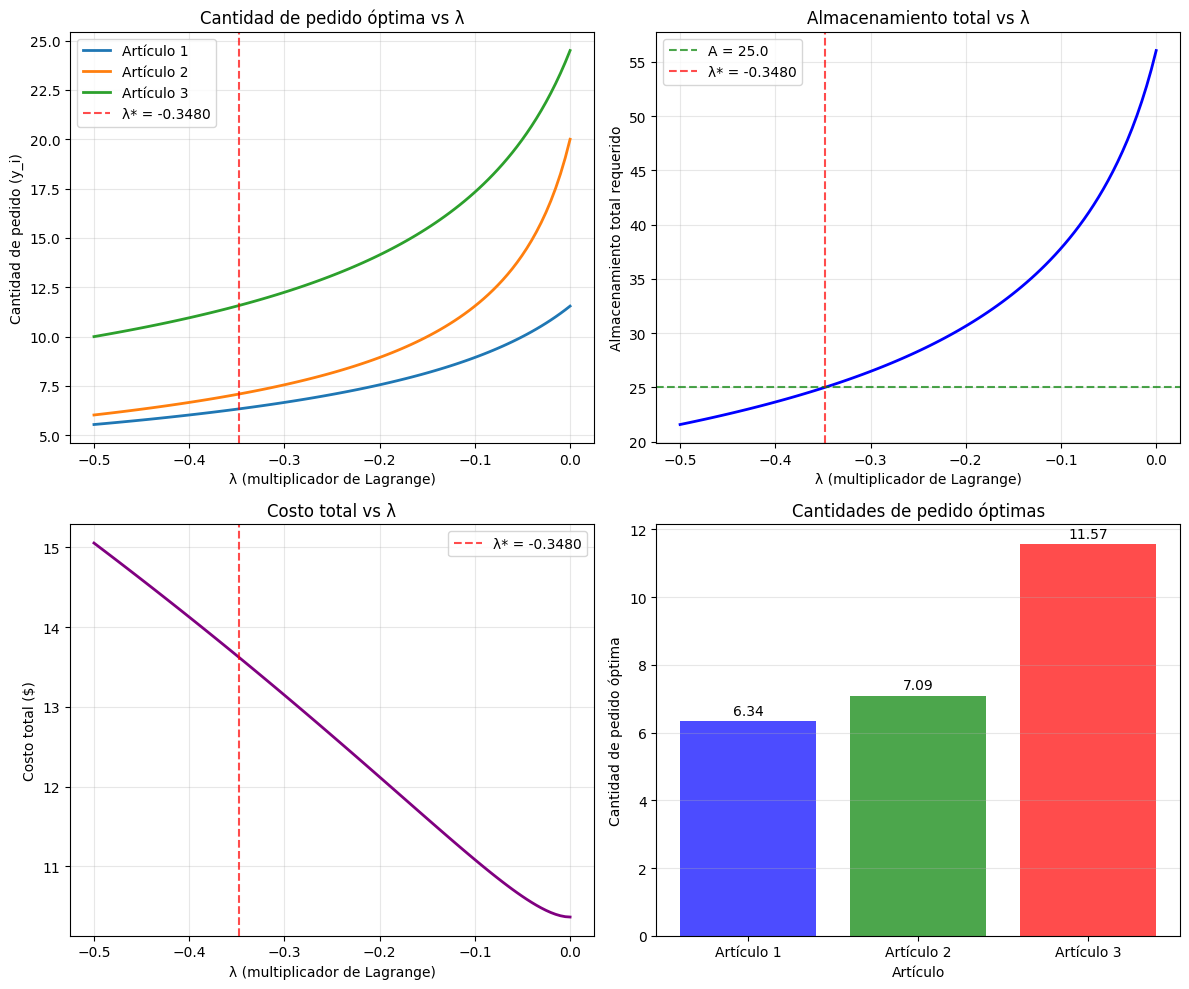

In [16]:
# PARTE 7: ANÁLISIS DE SENSIBILIDAD Y VISUALIZACIÓN
def analisis_sensibilidad(self, lambda_range=(-1, 0), n_points=50):
    """
    Análisis de sensibilidad: cómo cambian y_i y el costo con lambda
    """
    lambda_vals = np.linspace(lambda_range[0], lambda_range[1], n_points)

    # Excluir valores de lambda que hagan denominadores no positivos
    valid_lambda = []
    storage_vals = []
    cost_vals = []

    for lambd in lambda_vals:
        y_vals = self.y_i_lambda(lambd)
        if np.all(np.isfinite(y_vals)) and np.all(y_vals > 0):
            valid_lambda.append(lambd)
            storage_vals.append(np.sum(self.a * y_vals))
            cost_vals.append(np.sum(self.K * self.D / y_vals + self.h * y_vals / 2))

    return np.array(valid_lambda), np.array(storage_vals), np.array(cost_vals)

def visualizar_solucion(modelo, lambda_star, y_star):
    """
    Visualizar la solución y el análisis de sensibilidad
    """
    # Análisis de sensibilidad
    lambda_vals, storage_vals, cost_vals = modelo.analisis_sensibilidad(lambda_range=(-0.5, 0), n_points=100)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Gráfico 1: Cantidades de pedido vs lambda
    for i in range(modelo.n):
        y_i_vals = [modelo.y_i_lambda(l)[i] for l in lambda_vals]
        axes[0, 0].plot(lambda_vals, y_i_vals, label=f'Artículo {i+1}', linewidth=2)

    axes[0, 0].axvline(x=lambda_star, color='r', linestyle='--', alpha=0.7,
                      label=f'λ* = {lambda_star:.4f}')
    axes[0, 0].set_xlabel('λ (multiplicador de Lagrange)')
    axes[0, 0].set_ylabel('Cantidad de pedido (y_i)')
    axes[0, 0].set_title('Cantidad de pedido óptima vs λ')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Gráfico 2: Almacenamiento total vs lambda
    axes[0, 1].plot(lambda_vals, storage_vals, 'b-', linewidth=2)
    axes[0, 1].axhline(y=modelo.A, color='g', linestyle='--', alpha=0.7,
                      label=f'A = {modelo.A}')
    axes[0, 1].axvline(x=lambda_star, color='r', linestyle='--', alpha=0.7,
                      label=f'λ* = {lambda_star:.4f}')
    axes[0, 1].set_xlabel('λ (multiplicador de Lagrange)')
    axes[0, 1].set_ylabel('Almacenamiento total requerido')
    axes[0, 1].set_title('Almacenamiento total vs λ')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Gráfico 3: Costo total vs lambda
    axes[1, 0].plot(lambda_vals, cost_vals, 'purple', linewidth=2)
    axes[1, 0].axvline(x=lambda_star, color='r', linestyle='--', alpha=0.7,
                      label=f'λ* = {lambda_star:.4f}')
    axes[1, 0].set_xlabel('λ (multiplicador de Lagrange)')
    axes[1, 0].set_ylabel('Costo total ($)')
    axes[1, 0].set_title('Costo total vs λ')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Gráfico 4: Barras de cantidades óptimas
    x_pos = np.arange(modelo.n)
    axes[1, 1].bar(x_pos, y_star, alpha=0.7, color=['blue', 'green', 'red'])
    axes[1, 1].set_xlabel('Artículo')
    axes[1, 1].set_ylabel('Cantidad de pedido óptima')
    axes[1, 1].set_title('Cantidades de pedido óptimas')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels([f'Artículo {i+1}' for i in range(modelo.n)])

    # Añadir valores en las barras
    for i, v in enumerate(y_star):
        axes[1, 1].text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom')

    axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

# Añadir método de análisis de sensibilidad a la clase
EOQMultiItemConstrained.analisis_sensibilidad = analisis_sensibilidad

# Generar visualización
print("\n" + "=" * 60)
print("GENERANDO VISUALIZACIÓN DE RESULTADOS")
print("=" * 60)
visualizar_solucion(modelo, lambda_star, y_star)